[View in Colaboratory](https://colab.research.google.com/github/shravankumar9892/coloi/blob/master/coloi.ipynb)

# COLOI
You can visit the project webiste through this link: [COLOI](https://sites.google.com/view/coloi/)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# GPU Support 
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Loading image file into colab

image_downloaded = drive.CreateFile({'id':'1HzIKgbXGKcAvwsygYOTb4S3Sqxtn96ns'})
image_downloaded.GetContentFile('man.jpeg')

# **Object Detection**
![Inception](https://www.tensorflow.org/images/AlexClassification.png)

In [8]:
# Libraries

import keras
from keras.applications import inception_v3
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [24]:
# Taking input
# For object detection resize = (224, 224)
# resize has to be a tuple 

def input_image(resize):                     
  image_file = input('Enter the image file: ')
  img = cv2.imread(image_file, 1)            # Remember wrong image name will not give you an error.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting bgr into rgb values.
  if resize == None:
    pass
  else:
    img = cv2.resize(img, resize)
  return img.astype(float)

# Expanding image dimension along axis 0 on calling the function input_image
img = np.expand_dims(input_image(resize = (224, 224)), axis=0)

Enter the image file: man.jpeg


In [0]:
# Process the image by subtracting the mean of R, G, B respectively with the elements of the image array

input_img = inception_v3.preprocess_input(img.copy()) 

In [11]:
# Loading the pre-trained model

model = inception_v3.InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 6s 0us/step


In [12]:
# Prediction
predictions = model.predict(input_img)
predictions = decode_predictions(predictions)

40960/35363 [==================================] - 0s 3us/step


In [13]:
print('This image contains: \n\n' + predictions[0][0][1]+ ' with a % probability of: ' + str(predictions[0][0][2]*100))
print(predictions[0][1][1]+ ' with a % probability of: ' + str(predictions[0][1][2]*100))
print(predictions[0][2][1]+ ' with a % probability of: ' + str(predictions[0][2][2]*100))
print(predictions[0][3][1]+ ' with a % probability of: ' + str(predictions[0][3][2]*100))
print(predictions[0][4][1]+ ' with a % probability of: ' + str(predictions[0][4][2]*100))

This image contains: 

groom with a % probability of: 98.27573895454407
hair_spray with a % probability of: 0.2778796711936593
gown with a % probability of: 0.260498421266675
kimono with a % probability of: 0.21707143168896437
bikini with a % probability of: 0.20790703129023314


# Color Spaces
![Color Space](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRzCvTgNUnzRZzQ82_sTKnYj0GWqktiU8GlFNRr9TEPIDXSDPg5)

#### Various Types of Color Spaces available, run the code cell below

In [0]:
def flags():
  # To get flags, just run following code cell :
  flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
  print(flags)
  return None

#### Taking the input

In [15]:
image_file = input('Enter the image file: ')
img = cv2.imread(image_file, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Enter the image file: man.jpeg


#### Color Space Conversion

In [0]:
# Find suitable flag values from the function flags

def color_spaces(image, flag, save = False, show = True):
  img = cv2.cvtColor(image, flag)
  if show == True:
    plt.imshow(img)
    plt.show()
  else:
    pass
  if save == True:
    cv2.imwrite(input('Image shall be saved with which name? ', img))

# Image Colorization
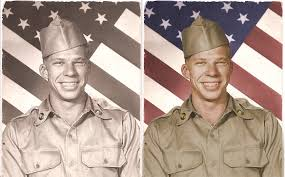

In [0]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

**Preprocessing**

In [0]:
def LUV(image, conversion = 1, inter = cv2.INTER_AREA):
    # Instead of loading images from the array, I'm doing everything again here so that it shouldn't give memory error.
    img = cv2.imread(image, 1)
    img = cv2.resize(img, (400,400), interpolation = inter)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    luv = (cv2.cvtColor(img,cv2.COLOR_RGB2LAB)+[0, 128, 128])/[100,255,255]
    return luv[:,:,0], luv[:,:,1:]

In [0]:
X, y = LUV('man.jpeg')
X = np.expand_dims(X, axis = 2)
X = np.expand_dims(X, axis = 0)
y = np.expand_dims(y, axis = 0)

**Model**

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [0]:
model.compile(optimizer='rmsprop', loss='mse')

**Training**

In [0]:
with tf.device('/gpu:0'):
  model.fit(x=X, y=y, batch_size=1, epochs=1000)

In [0]:
print(model.evaluate(X, y, batch_size=1))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
cur = cv2.cvtColor(cur, cv2.COLOR_LAB2RGB)
plt.imshow(cur)
plt.show()
imwrite("img_result.png", cur)